In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

from evolutionary_algorithm import EA

# Peptides

In [4]:
peptides_data_dir = "./data/peptides/"

ebola_data = pd.read_csv(peptides_data_dir + "ebola-6mers.txt", header=None)

ebola_data

,0
0,LEAMVN
1,DNFLYY
2,DEVLWE
3,YEAVYK
4,YDRLAS
...,...
135,GLISDW
136,LPIDFI
137,FWYDLA
138,LTLIKT


In [18]:
peptides = ebola_data[0].tolist()
peptide_length = len(peptides[0])

position_counts = [defaultdict(int) for _ in range(peptide_length)]

# count frequencies per position
for peptide in peptides:
    for i, aa in enumerate(peptide):
        position_counts[i][aa] += 1

# convert counts to frequencies
position_freqs = []
for pos in position_counts:
    total = sum(pos.values())
    pos_freq = {aa: count / total for aa, count in pos.items()}
    position_freqs.append(pos_freq)
    
def compute_Fpep(peptide, position_freqs):
    return sum(position_freqs[i].get(aa, 0) for i, aa in enumerate(peptide))

fpep_scores = [compute_Fpep(p, position_freqs) for p in peptides]

fpep_scores

[0.4,
 0.5642857142857143,
 0.5357142857142857,
 0.40714285714285714,
 0.6071428571428572,
 0.5428571428571429,
 0.6071428571428571,
 0.41428571428571426,
 0.4285714285714286,
 0.41428571428571426,
 0.6285714285714287,
 0.6428571428571429,
 0.6428571428571428,
 0.46428571428571425,
 0.4928571428571429,
 0.5071428571428572,
 0.3214285714285714,
 0.39999999999999997,
 0.6571428571428571,
 0.3214285714285714,
 0.4357142857142857,
 0.4928571428571429,
 0.5571428571428572,
 0.4928571428571428,
 0.5,
 0.45714285714285713,
 0.5714285714285714,
 0.35,
 0.33571428571428574,
 0.4285714285714286,
 0.6071428571428572,
 0.4642857142857143,
 0.5142857142857142,
 0.6000000000000001,
 0.40714285714285714,
 0.40714285714285714,
 0.27142857142857146,
 0.35714285714285715,
 0.49999999999999994,
 0.5642857142857143,
 0.3142857142857143,
 0.37857142857142856,
 0.2571428571428571,
 0.39999999999999997,
 0.32857142857142857,
 0.4714285714285715,
 0.5357142857142857,
 0.5857142857142857,
 0.4357142857142857,


In [74]:
def fitness(fpep_scores_set):
    if len(fpep_scores_set) == 0:
        return np.inf
    
    # Minimize avg fpep
    avg_fpep = np.mean(fpep_scores_set)
    
    # Maximize different kinds of fpep
    different_fpep = np.vnpar(fpep_scores_set)
    
    # 1 & 0    is the same as what we had before
    weight_avg = 1
    weight_different = 3.0

    return (weight_avg * avg_fpep) - (weight_different * different_fpep)
    
    

In [75]:
ea = EA(
    data=fpep_scores,
    N=100,
    sigma=30,
    K=2,
    p=0.1,
    mu=0.01,
    T=1000,
    f=np.mean,
    seed=42
)
best_individual, best_fitness, fitness_avg, fitness_best = ea.run()

m_ea = EA(
    data=fpep_scores,
    N=100,
    sigma=30,
    K=2,
    p=0.1,
    mu=0.01,
    T=1000,
    f=fitness,
    seed=42
)
multi_best_individual, multi_best_fitness, multi_fitness_avg, multi_fitness_best = m_ea.run()

Gen 1: Best = 0.4173809523809524, Avg = 0.45159285714285713
Gen 2: Best = 0.41238095238095235, Avg = 0.44056666666666666
Gen 3: Best = 0.40833333333333327, Avg = 0.4346571428571429
Gen 4: Best = 0.40666666666666657, Avg = 0.43073333333333336
Gen 5: Best = 0.4023809523809524, Avg = 0.42718333333333325
Gen 6: Best = 0.3985714285714286, Avg = 0.42259523809523797
Gen 7: Best = 0.3983333333333334, Avg = 0.419302380952381
Gen 8: Best = 0.4007142857142857, Avg = 0.4166095238095238
Gen 9: Best = 0.39595238095238094, Avg = 0.4141785714285713
Gen 10: Best = 0.3971428571428571, Avg = 0.41122142857142857
Gen 11: Best = 0.392142857142857, Avg = 0.40886190476190476
Gen 12: Best = 0.38928571428571423, Avg = 0.40722857142857144
Gen 13: Best = 0.3861904761904762, Avg = 0.4042452380952382
Gen 14: Best = 0.38285714285714284, Avg = 0.4030285714285714
Gen 15: Best = 0.3845238095238095, Avg = 0.40162619047619047
Gen 16: Best = 0.3840476190476191, Avg = 0.3996714285714285
Gen 17: Best = 0.38119047619047625, 

Gen 169: Best = 0.350952380952381, Avg = 0.3731238095238094
Gen 170: Best = 0.3545238095238095, Avg = 0.3722785714285714
Gen 171: Best = 0.3511904761904762, Avg = 0.3717476190476191
Gen 172: Best = 0.3547619047619047, Avg = 0.3709261904761905
Gen 173: Best = 0.3521428571428571, Avg = 0.3696642857142858
Gen 174: Best = 0.35261904761904755, Avg = 0.36742857142857155
Gen 175: Best = 0.3547619047619048, Avg = 0.367804761904762
Gen 176: Best = 0.3564285714285714, Avg = 0.36768095238095233
Gen 177: Best = 0.3549999999999999, Avg = 0.3677761904761905
Gen 178: Best = 0.35333333333333333, Avg = 0.3686738095238096
Gen 179: Best = 0.35666666666666663, Avg = 0.36923333333333325
Gen 180: Best = 0.3569047619047619, Avg = 0.36893333333333345
Gen 181: Best = 0.3576190476190477, Avg = 0.36977619047619037
Gen 182: Best = 0.35476190476190467, Avg = 0.3712857142857142
Gen 183: Best = 0.3573809523809523, Avg = 0.3726404761904761
Gen 184: Best = 0.35833333333333334, Avg = 0.3731714285714285
Gen 185: Best = 

Gen 340: Best = 0.35833333333333334, Avg = 0.37535952380952387
Gen 341: Best = 0.3604761904761905, Avg = 0.3754428571428572
Gen 342: Best = 0.36071428571428565, Avg = 0.37553333333333344
Gen 343: Best = 0.36142857142857143, Avg = 0.3737166666666667
Gen 344: Best = 0.36309523809523814, Avg = 0.3738833333333334
Gen 345: Best = 0.36238095238095247, Avg = 0.3752476190476191
Gen 346: Best = 0.3635714285714286, Avg = 0.37485000000000007
Gen 347: Best = 0.359047619047619, Avg = 0.37618809523809527
Gen 348: Best = 0.3571428571428571, Avg = 0.376154761904762
Gen 349: Best = 0.359047619047619, Avg = 0.3763976190476191
Gen 350: Best = 0.36095238095238097, Avg = 0.3762738095238095
Gen 351: Best = 0.36476190476190473, Avg = 0.37704285714285724
Gen 352: Best = 0.3609523809523809, Avg = 0.3778952380952381
Gen 353: Best = 0.36642857142857144, Avg = 0.37926666666666653
Gen 354: Best = 0.365, Avg = 0.3809357142857143
Gen 355: Best = 0.3642857142857142, Avg = 0.37970476190476193
Gen 356: Best = 0.3638095

Gen 531: Best = 0.36095238095238097, Avg = 0.3756214285714286
Gen 532: Best = 0.35999999999999993, Avg = 0.3752571428571428
Gen 533: Best = 0.3592857142857143, Avg = 0.3757238095238095
Gen 534: Best = 0.35666666666666674, Avg = 0.374895238095238
Gen 535: Best = 0.36047619047619045, Avg = 0.3737404761904762
Gen 536: Best = 0.35952380952380947, Avg = 0.3739904761904762
Gen 537: Best = 0.35904761904761906, Avg = 0.37485238095238094
Gen 538: Best = 0.3623809523809524, Avg = 0.37540714285714283
Gen 539: Best = 0.3633333333333333, Avg = 0.3762571428571428
Gen 540: Best = 0.3614285714285713, Avg = 0.37598333333333334
Gen 541: Best = 0.3604761904761905, Avg = 0.37632380952380956
Gen 542: Best = 0.3604761904761905, Avg = 0.37755952380952373
Gen 543: Best = 0.35952380952380947, Avg = 0.37785238095238094
Gen 544: Best = 0.3607142857142857, Avg = 0.37692619047619047
Gen 545: Best = 0.3604761904761905, Avg = 0.37607142857142845
Gen 546: Best = 0.3585714285714286, Avg = 0.37449285714285707
Gen 547: 

Gen 711: Best = 0.3578571428571428, Avg = 0.37328571428571417
Gen 712: Best = 0.35928571428571426, Avg = 0.37385476190476186
Gen 713: Best = 0.35928571428571426, Avg = 0.37453333333333333
Gen 714: Best = 0.3611904761904762, Avg = 0.3734119047619046
Gen 715: Best = 0.3595238095238095, Avg = 0.37283095238095243
Gen 716: Best = 0.35928571428571426, Avg = 0.37293571428571426
Gen 717: Best = 0.35714285714285715, Avg = 0.3728190476190476
Gen 718: Best = 0.3576190476190476, Avg = 0.37360952380952384
Gen 719: Best = 0.35785714285714293, Avg = 0.37372619047619055
Gen 720: Best = 0.35928571428571426, Avg = 0.3739309523809525
Gen 721: Best = 0.3585714285714286, Avg = 0.3744166666666667
Gen 722: Best = 0.35904761904761906, Avg = 0.37521904761904773
Gen 723: Best = 0.3604761904761905, Avg = 0.37578333333333336
Gen 724: Best = 0.35904761904761906, Avg = 0.376295238095238
Gen 725: Best = 0.35904761904761906, Avg = 0.3753523809523809
Gen 726: Best = 0.35523809523809535, Avg = 0.37489047619047616
Gen 7

Gen 899: Best = 0.3457142857142858, Avg = 0.3704380952380953
Gen 900: Best = 0.34738095238095246, Avg = 0.36987619047619047
Gen 901: Best = 0.34690476190476194, Avg = 0.369997619047619
Gen 902: Best = 0.34714285714285714, Avg = 0.3698571428571427
Gen 903: Best = 0.3519047619047619, Avg = 0.3699952380952381
Gen 904: Best = 0.3497619047619048, Avg = 0.37000952380952384
Gen 905: Best = 0.3530952380952382, Avg = 0.3710214285714287
Gen 906: Best = 0.35095238095238096, Avg = 0.37115000000000004
Gen 907: Best = 0.3550000000000001, Avg = 0.3718
Gen 908: Best = 0.3592857142857144, Avg = 0.373404761904762
Gen 909: Best = 0.3576190476190477, Avg = 0.37328333333333336
Gen 910: Best = 0.3557142857142858, Avg = 0.3735404761904762
Gen 911: Best = 0.35714285714285715, Avg = 0.37340476190476196
Gen 912: Best = 0.3573809523809524, Avg = 0.37288809523809535
Gen 913: Best = 0.35976190476190484, Avg = 0.3730023809523809
Gen 914: Best = 0.3614285714285714, Avg = 0.37314523809523803
Gen 915: Best = 0.3538095

Gen 39: Best = 0.35471156462585035, Avg = 0.3625256632653062
Gen 40: Best = 0.3523918367346939, Avg = 0.36305624489795923
Gen 41: Best = 0.34904676870748297, Avg = 0.3620276513605441
Gen 42: Best = 0.34713197278911573, Avg = 0.36139217517006805
Gen 43: Best = 0.35226377551020405, Avg = 0.36145147789115645
Gen 44: Best = 0.3525270408163265, Avg = 0.3622169404761905
Gen 45: Best = 0.34972176870748306, Avg = 0.3616814132653062
Gen 46: Best = 0.3499448979591837, Avg = 0.3611637482993198
Gen 47: Best = 0.34969030612244895, Avg = 0.36045474999999993
Gen 48: Best = 0.3495324829931973, Avg = 0.36045553741496605
Gen 49: Best = 0.3502957482993197, Avg = 0.36048214965986397
Gen 50: Best = 0.3504020408163266, Avg = 0.35995092687074826
Gen 51: Best = 0.3512855442176871, Avg = 0.3604834659863945
Gen 52: Best = 0.34428826530612244, Avg = 0.35966971938775516
Gen 53: Best = 0.3492229591836735, Avg = 0.36000980952380957
Gen 54: Best = 0.34863112244897965, Avg = 0.3599546020408163
Gen 55: Best = 0.348432

Gen 188: Best = 0.3458079931972789, Avg = 0.35460356292517
Gen 189: Best = 0.3449202380952381, Avg = 0.3542315442176871
Gen 190: Best = 0.346230612244898, Avg = 0.35435678571428575
Gen 191: Best = 0.3441768707482993, Avg = 0.3547125527210885
Gen 192: Best = 0.3456428571428571, Avg = 0.354862962585034
Gen 193: Best = 0.3456197278911565, Avg = 0.35449692176870756
Gen 194: Best = 0.34387397959183674, Avg = 0.3546128299319728
Gen 195: Best = 0.34427278911564624, Avg = 0.35438956802721094
Gen 196: Best = 0.3429687074829932, Avg = 0.353725238095238
Gen 197: Best = 0.3442535714285714, Avg = 0.35315882142857136
Gen 198: Best = 0.344763775510204, Avg = 0.35291159183673465
Gen 199: Best = 0.3435551020408163, Avg = 0.3525923605442177
Gen 200: Best = 0.34565714285714283, Avg = 0.35300654421768707
Gen 201: Best = 0.34450408163265306, Avg = 0.35357244387755105
Gen 202: Best = 0.34409166666666674, Avg = 0.35363913605442177
Gen 203: Best = 0.3440979591836734, Avg = 0.35397338435374154
Gen 204: Best = 

Gen 328: Best = 0.34262857142857145, Avg = 0.35386152891156464
Gen 329: Best = 0.3434304421768707, Avg = 0.35486382653061227
Gen 330: Best = 0.3448530612244898, Avg = 0.3554435646258503
Gen 331: Best = 0.3406727891156463, Avg = 0.3566838673469388
Gen 332: Best = 0.3438204081632653, Avg = 0.3564123758503402
Gen 333: Best = 0.34391479591836727, Avg = 0.3562634659863946
Gen 334: Best = 0.34391479591836727, Avg = 0.3571074523809524
Gen 335: Best = 0.3442739795918367, Avg = 0.35654676190476203
Gen 336: Best = 0.3438739795918368, Avg = 0.35595368877551015
Gen 337: Best = 0.3434100340136055, Avg = 0.3554797057823129
Gen 338: Best = 0.34317959183673474, Avg = 0.35491560204081635
Gen 339: Best = 0.3437637755102041, Avg = 0.3544546683673469
Gen 340: Best = 0.337659693877551, Avg = 0.3544318010204082
Gen 341: Best = 0.3446632653061224, Avg = 0.354721212585034
Gen 342: Best = 0.3418801020408163, Avg = 0.3538860714285714
Gen 343: Best = 0.3366324829931973, Avg = 0.35314309013605455
Gen 344: Best = 

Gen 485: Best = 0.3478136054421768, Avg = 0.3603872738095238
Gen 486: Best = 0.34661836734693874, Avg = 0.36055119217687076
Gen 487: Best = 0.3486020408163265, Avg = 0.36023593877551024
Gen 488: Best = 0.348825, Avg = 0.36041060714285705
Gen 489: Best = 0.34380000000000005, Avg = 0.3594507738095238
Gen 490: Best = 0.34614285714285725, Avg = 0.3596353996598639
Gen 491: Best = 0.34797687074829936, Avg = 0.3593638843537415
Gen 492: Best = 0.3473938775510204, Avg = 0.3599815612244898
Gen 493: Best = 0.34891768707482995, Avg = 0.36041321768707485
Gen 494: Best = 0.35046666666666665, Avg = 0.3597891870748299
Gen 495: Best = 0.34787346938775504, Avg = 0.36074763435374146
Gen 496: Best = 0.3499360544217688, Avg = 0.3604463537414966
Gen 497: Best = 0.3508773809523809, Avg = 0.3599258214285714
Gen 498: Best = 0.3504972789115647, Avg = 0.3600517278911564
Gen 499: Best = 0.34876122448979596, Avg = 0.3596902534013606
Gen 500: Best = 0.3443528911564626, Avg = 0.36082780952380955
Gen 501: Best = 0.34

Gen 625: Best = 0.34944540816326536, Avg = 0.3596274540816327
Gen 626: Best = 0.34773877551020416, Avg = 0.3591020986394558
Gen 627: Best = 0.34714540816326545, Avg = 0.35969389115646266
Gen 628: Best = 0.34908095238095255, Avg = 0.3594307959183674
Gen 629: Best = 0.3488903061224491, Avg = 0.3600642959183674
Gen 630: Best = 0.34765714285714294, Avg = 0.35964940476190477
Gen 631: Best = 0.34736462585034006, Avg = 0.360420988095238
Gen 632: Best = 0.346955612244898, Avg = 0.3586174829931974
Gen 633: Best = 0.3468127551020409, Avg = 0.35907229931972795
Gen 634: Best = 0.34889982993197294, Avg = 0.3582373231292517
Gen 635: Best = 0.34889982993197294, Avg = 0.35781778061224484
Gen 636: Best = 0.3498156462585035, Avg = 0.3591776819727891
Gen 637: Best = 0.3468197278911566, Avg = 0.35940710204081633
Gen 638: Best = 0.3487442176870748, Avg = 0.3604094574829933
Gen 639: Best = 0.3491163265306122, Avg = 0.36082624319727896
Gen 640: Best = 0.34625442176870747, Avg = 0.3598970306122449
Gen 641: Be

Gen 789: Best = 0.34304829931972797, Avg = 0.3551774081632653
Gen 790: Best = 0.34771003401360545, Avg = 0.3551121785714286
Gen 791: Best = 0.3438290816326531, Avg = 0.35615125680272114
Gen 792: Best = 0.3429755102040816, Avg = 0.35611158843537416
Gen 793: Best = 0.3453258503401361, Avg = 0.35600438775510207
Gen 794: Best = 0.34394540816326535, Avg = 0.35670226530612253
Gen 795: Best = 0.3421413265306124, Avg = 0.3564559149659864
Gen 796: Best = 0.3463238095238095, Avg = 0.3560633350340136
Gen 797: Best = 0.34769234693877554, Avg = 0.3570205782312925
Gen 798: Best = 0.34581819727891155, Avg = 0.35688139795918367
Gen 799: Best = 0.3453238095238096, Avg = 0.3564202534013606
Gen 800: Best = 0.34694285714285716, Avg = 0.35759636224489805
Gen 801: Best = 0.34660544217687084, Avg = 0.3577409013605443
Gen 802: Best = 0.34449982993197276, Avg = 0.35854918707483
Gen 803: Best = 0.34488010204081637, Avg = 0.35775646598639455
Gen 804: Best = 0.3462013605442178, Avg = 0.3576186037414965
Gen 805: B

Gen 929: Best = 0.3437204081632652, Avg = 0.3545750714285715
Gen 930: Best = 0.3458646258503401, Avg = 0.3550348350340136
Gen 931: Best = 0.34442704081632647, Avg = 0.3552716088435374
Gen 932: Best = 0.3452311224489796, Avg = 0.3558107448979591
Gen 933: Best = 0.3452311224489796, Avg = 0.3555812312925169
Gen 934: Best = 0.34219795918367346, Avg = 0.3555410238095238
Gen 935: Best = 0.345638775510204, Avg = 0.35517428911564614
Gen 936: Best = 0.34516173469387745, Avg = 0.35597534863945585
Gen 937: Best = 0.3434862244897959, Avg = 0.3553808197278912
Gen 938: Best = 0.34530867346938776, Avg = 0.3551679795918367
Gen 939: Best = 0.34373112244897963, Avg = 0.3559962908163265
Gen 940: Best = 0.3479326530612245, Avg = 0.3571209676870748
Gen 941: Best = 0.3487489795918367, Avg = 0.3578116581632652
Gen 942: Best = 0.3505678571428571, Avg = 0.3602758299319727
Gen 943: Best = 0.3494821428571429, Avg = 0.3601329897959184
Gen 944: Best = 0.3471617346938775, Avg = 0.3590420697278911
Gen 945: Best = 0.

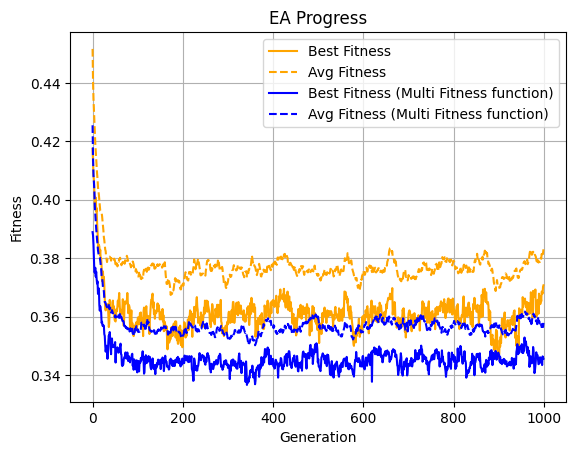

In [76]:
plt.plot(fitness_best, label='Best Fitness', linestyle='-', color='orange')
plt.plot(fitness_avg, label='Avg Fitness', linestyle='--', color='orange')
plt.plot(multi_fitness_best, label='Best Fitness (Multi Fitness function)', linestyle='-', color='blue')
plt.plot(multi_fitness_avg, label='Avg Fitness (Multi Fitness function)', linestyle='--', color='blue')
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("EA Progress")
plt.legend()
plt.grid(True)
plt.show()

In [63]:
optimal_peptides = [peptides[i] for i in best_individual]
optimal_peptides

['SDSACG',
 'WLNDNL',
 'WKVNPE',
 'SDVPVA',
 'GSDGYK',
 'WTSISC',
 'MHNQDG',
 'YHRYNL',
 'PKHIYR',
 'TYPKIG',
 'QAIMTS',
 'MFFWYD',
 'IFETYC',
 'ICGLRQ',
 'KPDETF',
 'MRTNFL',
 'SLIRSN',
 'QDSEVK',
 'ALAVPQ',
 'DWYQAS',
 'HQGMHM',
 'FNWMHY',
 'TTQIHN',
 'LWEFYH',
 'SDTEGM',
 'DAAPPV',
 'REAIEL',
 'TFVKEW',
 'EQENFS',
 'DHCDNI']

In [64]:
multi_optimal_peptides = [peptides[i] for i in multi_best_individual]
multi_optimal_peptides

['DWYQAS',
 'FNWMHY',
 'YHRYNL',
 'GSDGYK',
 'DAAPPV',
 'VPVLLK',
 'DHCDNI',
 'MTGRIP',
 'MKDEPV',
 'EELLPA',
 'NEENRF',
 'IQITKR',
 'MHNQDG',
 'SDVPVA',
 'LIQKYQ',
 'IERLTG',
 'LWEFYH',
 'FHTFFS',
 'EQENFS',
 'SHLTQY',
 'LASLAT',
 'WTSISC',
 'HQGMHM',
 'TYPKIG',
 'WLNDNL',
 'QDSEVK',
 'TTQIHN',
 'LTAGLS',
 'SDTEGM',
 'PKHIYR']